In [1]:
import ctypes
import datetime
import glob
import gzip
import json
import os
import shutil
import tarfile

import csmapi
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams

import ale
import gdal
import osr
import pvl
import spiceypy as spice
from ale.drivers import JsonEncoder
from ale.drivers.kaguya_drivers import KaguyaTcPds3NaifSpiceDriver

import knoten
from knoten import csm

In [2]:
# Decompress .sl2 files 
files = glob.glob('*.sl2')
for f in files:
    tar = tarfile.open(f)
    
    # Extract the spc and the ctg files
    for m in tar.getmembers():
        tar.extract(m, "images")
    imageid = os.path.splitext(os.path.basename(f))[0]
    
    # decompress .igz file containing image data
    with gzip.open('images/{}.igz'.format(imageid), 'rb') as f_in:
        with open('images/{}.img'.format(imageid), 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [3]:
image = "images/TC2W2B0_01_00366S490E1640.img"
gtifimage = os.path.splitext(image)[0]+".tif"
alelabel = os.path.splitext(image)[0]+".json"
vrtfile = os.path.splitext(image)[0]+".vrt"

label = pvl.load(image)
driver = KaguyaTcPds3NaifSpiceDriver(image)

with driver as d:
    aledict = d.to_dict()

json.dump(aledict, open(alelabel, "w"), cls=JsonEncoder)

nlines, nsamples = aledict["image_lines"], aledict["image_samples"]

model="USGS_ASTRO_LINE_SCANNER_SENSOR_MODEL"
plugin = csmapi.Plugin.getList()[0]
isd = csmapi.Isd(alelabel)
camera = plugin.constructModelFromISD(isd, model)

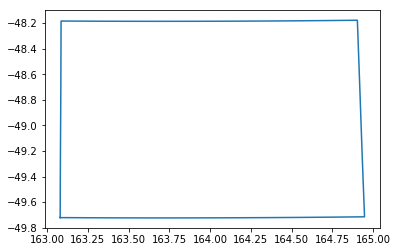

In [18]:
# a/b for the moon
semi_major = aledict["radii"]["semimajor"] * 1000 # scale to meters
semi_minor = aledict["radii"]["semiminor"] * 1000 # scale to meters

imgbounds = csm.generate_boundary((nlines, nsamples))
gcps = csm.generate_gcps(camera, imgbounds, semi_major, semi_minor)
vrt = csm.generate_vrt((nsamples, nlines), gcps, gtifimage, proj='+proj=longlat +a={} +b={} +no_defs'.format(semi_major, semi_minor))
with open(vrtfile, "w") as f:
    f.write(vrt)
    
# plot footprint
lats, lons, alts = csm.generate_latlon_boundary(camera, imgbounds, semi_major, semi_minor)
plt.plot(lats, lons)
plt.show()

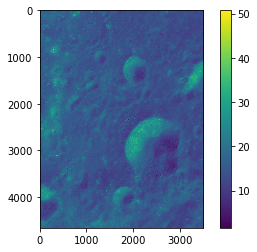

In [5]:
# GDAL cannot currently read kaguya images, so we need to open them manually for visualization 
imagebytes = open(image, "rb").read()
arr = np.frombuffer(imagebytes[aledict["label"]["^IMAGE"].value-1:], dtype=">i2")

scale = pvl.load(image)["IMAGE"]["SCALING_FACTOR"]
arr = arr*scale
arr = arr.reshape(nlines, nsamples)

# plot unprojected 
plt.imshow(arr)
plt.colorbar()
plt.show()

In [6]:
def array2raster(rasterfn, array, newRasterfn):
    """
    Writes an array to a GeoDataset using another dataset as reference. Borrowed  
    from: https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html
    
    Parameters 
    ----------
    rasterfn : str, GeoDataset
               Dataset or path to the dataset to use as a reference. Geotransform 
               and spatial reference information is copied into the new image. 
               
    array : np.array 
            Array to write 
            
    newRasterfn : str 
                  Filename for new raster image 
    
    Returns
    -------
    : GeoDataset 
      File handle for the new raster file
      
    """
    naxis = len(array.shape)
    assert naxis == 2 or naxis == 3      
    
    nbands = 1
    
    raster = gdal.Open(rasterfn, gdal.GA_ReadOnly)
    geotransform = raster.GetGeoTransform()
    originX = geotransform[0]
    originY = geotransform[3]
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    cols = array.shape[1]
    rows = array.shape[0]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, nbands, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    

    outband = outRaster.GetRasterBand(1)
    # Bands use indexing starting at 1
    outband.WriteArray(array)
    outband.FlushCache()

    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromWkt(raster.GetProjectionRef())
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    del outRaster


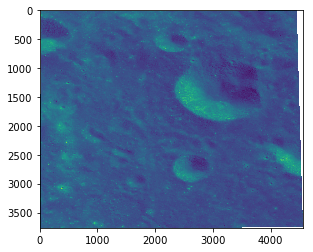

In [11]:
# save geotiff
array2raster(vrtfile, arr, gtifimage)
fd = gdal.Warp("{}.tif".format(image), vrtfile, srcNodata=0, dstNodata=-9999999)

# draw projected image
image_arr = fd.ReadAsArray()
# set no data to np.nan so it doesn't affect the stretch
image_arr[image_arr == -9999999] = np.nan
plt.imshow(image_arr)
plt.show()